In [179]:
f = open('Profile-20180724T170454_abcnews', 'r')

In [180]:
import json

profile = json.load(f)

In [181]:
profile_events = []

for row in profile:
    if row['ph'] == 'I' and row['name'] == 'CpuProfile':
        profile_events.append(row)

In [182]:
import math

def parse_times(data):
    start_time = math.floor(data['cpuProfile']['startTime'] / 1000000) * 1000000
    end_time = math.ceil(data['cpuProfile']['endTime'] / 1000000) * 1000000
    return start_time, end_time

In [183]:
def parse_nodes(data):
    idle_id = None
    nodes = {}
    for node in data['cpuProfile']['nodes']:
        node_id = node['id']
        function_name = node['callFrame']['functionName']
        url = node['callFrame']['url']
        line_number = node['callFrame']['lineNumber']
        children = node.get('children')
        hit_count = node.get('hitCount')
        nodes[node_id] = {'function_name': function_name, 'url': url, 'line_number': line_number, 'hit_count': hit_count, 'children': children}
        if function_name == '(idle)':
            idle_id = node_id
    return nodes, idle_id

In [184]:
COLUMN_DURATION = 1000000 # 1 second

def build_heatmap(data, start_time, interval, heatmap):
    time_deltas = data['cpuProfile']['timeDeltas']
    samples = data['cpuProfile']['samples']
    nodes, idle_id = parse_nodes(data)
    current_time = get_lead_time(data, start_time)

    for index, delta in enumerate(time_deltas):
        current_time += delta
        if samples[index] != idle_id:
            col_index = int(current_time // COLUMN_DURATION)
            row_index = int(math.floor((current_time % COLUMN_DURATION) / interval))
            heatmap[col_index][row_index] += 1
    return heatmap

In [185]:
def get_lead_time(data, start_time):
    return data['cpuProfile']['startTime'] - start_time

In [186]:
global_start_time = None
global_end_time = None

for profile in profile_events:
    data = profile['args']['data']
    start_time, end_time = parse_times(data)
    if global_start_time is None or start_time < global_start_time:
        global_start_time = start_time
    if global_end_time is None or end_time > global_end_time:
        global_end_time = end_time
        
duration = global_end_time - global_start_time

print(global_start_time, global_end_time, duration)

197976000000 197983000000 7000000


In [187]:
ROWS = 50 # 20 ms

interval = COLUMN_DURATION / ROWS
columns = duration / interval / ROWS

heatmap = [[0 for i in range(ROWS)] for j in range(int(columns))]

In [188]:
for profile in profile_events:
    data = profile['args']['data']
    heatmap = build_heatmap(data, global_start_time, interval, heatmap)

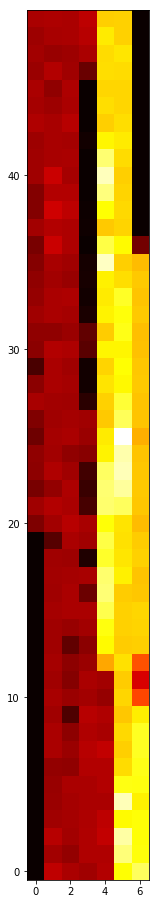

In [189]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16, 16]

plt.imshow(np.transpose(heatmap), cmap='hot', origin='lower')
plt.show()